In [1]:

import sys
sys.path
sys.path.append('/Users/agos/Dropbox/ColumbiaProjects/Code_Dans_Package/analysis_dan')
sys.path.append('/Users/agos/Dropbox/ColumbiaProjects/Code_Dans_Package/OASIS-master')

%matplotlib inline

import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob

import calnet.calnet as cc
import calnet.dynamics as dyn

import multiprocessing as mp
import opto_utils
import pyute as ut
import scipy.stats as sst
import pyute as ut
import naka_rushton_analysis as nra



from importlib import reload

%load_ext autoreload
%autoreload 2

In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/

In [2]:
calnet_base = '/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/calnet_data/'
Niter = int(1e3)
opto_levels = 1*np.linspace(0,1,11)
#opto_levels = np.array((0,0.5))
dt = 1e-1
sim_options = {}


for lbl,val in zip(['Niter','opto_levels','dt'],[Niter,opto_levels,dt]):
    sim_options[lbl] = val

vip_chrimson_l4_npyfile = calnet_base+'vip_chrimson_l4_data.npy'

In [3]:
# mdls, mdls_adjust=build_models(weights_files, return_non_adjust=True)
# mdls_adjust[0].XX.shape


In [8]:


def compute_opto_line(scall_chrimson_l4):
    this_data = np.nanmean(scall_chrimson_l4,3)
    xdata = this_data[:,:,:,0]
    ydata = this_data[:,:,:,1]
    xdata = xdata.flatten()
    ydata = ydata.flatten()
    lkat = ~np.isnan(xdata) & ~np.isnan(ydata)
    opto_slope,opto_intercept,_,_,_ = sst.linregress(xdata[lkat],ydata[lkat])
    return opto_slope,opto_intercept

def adjust_XX(mdl):
    mdl.XX[:,0::2] = mdl.XX[:,0::2]*opto_slope + opto_intercept*mdl.XX[:,0::2].mean(0,keepdims=True)
    return mdl

def build_models(weights_files):
    #weights_files = np.load(weights_files_list_file,allow_pickle=True)
    nwt = len(weights_files)
    mdls = [None for iwt in range(nwt)]
    for iwt in range(nwt):
        wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
        mdls[iwt] = cc.ModelOri(wtdict,nT=1)
        # mdls[iwt] = adjust_XX(mdls[iwt])
    return mdls


def get_low_loss_files(weights_files_orig):

    def get_loss_dist(weights_files):
        nwt = len(weights_files)
        losses = np.zeros((nwt,))
        for iwt in range(nwt):
            wtdict = np.load(weights_files[iwt],allow_pickle=True)[()];
            losses[iwt] = cc.ModelOri(wtdict,nT=1).loss
        low_loss = (losses<np.nanpercentile(losses,10))
        return low_loss

    low_loss=get_loss_dist(weights_files_orig)
    weights_files = [wf for (wf,ll) in zip(weights_files_orig,low_loss) if ll]
    return weights_files




def run_on_mdl(mdl,sim_options):
    Niter,opto_levels,dt = [sim_options[key] for key in ['Niter','opto_levels','dt']]
    average_last = int(np.floor(Niter/5))
    fix_dim = [2,6]
    this_YY_opto = dyn.compute_steady_state_Model(mdl,Niter=Niter,fix_dim=fix_dim,inj_mag=opto_levels,sim_type='inj',dt=dt)
    to_return = np.nanmean(this_YY_opto[:,:,-average_last:],2)
    return to_return

def simulate_opto_effects(mdls,sim_options=sim_options,pool_size=1):
    nwt = len(mdls)
    Niter,opto_levels,dt = [sim_options[key] for key in ['Niter','opto_levels','dt']]
    nopto = sim_options['opto_levels'].size
    if pool_size==1:
        YY_opto_tavg = np.zeros((nwt,nopto)+mdls[0].Eta.shape)
        for iwt in range(nwt):
            print('model #%d'%iwt)
            YY_opto_tavg[iwt] = run_on_mdl(mdls[iwt],sim_options)
    else:
        with mp.Pool(pool_size) as p:
            YY_opto_tavg = p.starmap(run_on_mdl,[(m,sim_options) for m in mdls])
        YY_opto_tavg = np.array(YY_opto_tavg)

    return YY_opto_tavg

def build_models_and_simulate_opto_effects(weights_files,target_file,sim_options=sim_options,pool_size=1):
    mdls = build_models(weights_files)
    nwt = len(mdls)
    YY_opto_tavg = simulate_opto_effects(mdls,sim_options=sim_options,pool_size=pool_size)
    iwt = 0
    nQ,nS,nT = mdls[iwt].nQ,mdls[iwt].nS,mdls[iwt].nT
    bltiles = np.zeros((nwt,nQ*nS*nT))
    amps = np.ones((nwt,nQ*nS*nT))
    for iwt in tqdm(range(nwt)):
        wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
        if 'bl' in wtdict:
            bl = wtdict['bl']
            bltiles[iwt] = np.tile(bl,nS*nT)
        if 'amp' in wtdict:
            amp = wtdict['amp']
            amps[iwt] = amp
    YY_opto_tavg = amps[:,np.newaxis,np.newaxis,:]*YY_opto_tavg + bltiles[:,np.newaxis,np.newaxis,:]
    XX_opto = np.concatenate([mdl.XX[np.newaxis] for mdl in mdls],axis=0)
    np.save(target_file,{'YY_opto':YY_opto_tavg,'XX_opto':XX_opto})

def run(fit_lbl,calnet_base=calnet_base,sim_options=sim_options,pool_size=1):
    weights_fold = calnet_base + 'weights/weights_%s/'%fit_lbl
    weights_files_orig = glob.glob(weights_fold+'*.npy')
    weights_files_orig.sort()
    weights_files = get_low_loss_files(weights_files_orig)
    print("from your original list of "+str(len(weights_files_orig))+' models you are computing ' +str(len(weights_files)))
    target_file = calnet_base + 'dynamics/vip_chrimson_opto_tavg_%s.npy'%fit_lbl
    build_models_and_simulate_opto_effects(weights_files,target_file,sim_options=sim_options,pool_size=pool_size)


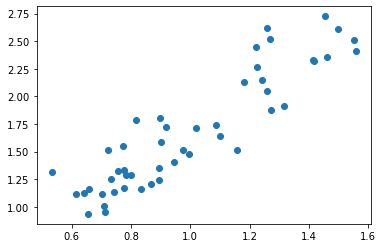

In [9]:

scallanimal_aligned = np.load(vip_chrimson_l4_npyfile,allow_pickle=True)[()]['scallanimal_aligned']
scall_chrimson_l4 = opto_utils.norm_to_mean_light_off(scallanimal_aligned)
opto_slope,opto_intercept = compute_opto_line(scall_chrimson_l4)

this_data = np.nanmean(scall_chrimson_l4,3)
xdata = this_data[:,:,:,0]
ydata = this_data[:,:,:,1]
xdata = xdata.flatten()
ydata = ydata.flatten()
plt.plot(xdata,ydata,'o')



In [10]:
fit_lbl = '210513c_baby'# sys.argv[1]
print(fit_lbl)
if len(sys.argv)==3:
    pool_size = int(sys.argv[2])
    run(fit_lbl,pool_size=pool_size)
elif len(sys.argv)>3:
    pool_size = int(sys.argv[2])
    calnet_base = sys.argv[3]
    run(fit_lbl,pool_size=pool_size,calnet_base=calnet_base)
else:
    run(fit_lbl)

210513c_baby


/Users/agos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


from your original list of 950 models you are computing 94
model #0
sim type: inj
False
model #1
sim type: inj
False
model #2
sim type: inj
False
model #3
sim type: inj
False
model #4
sim type: inj
False
model #5
sim type: inj
False
model #6


### Load output

In [ ]:
fit_lbl='210513c_baby'
calnet_base + 'dynamics/vip_chrimson_l4_opto_tavg_%s.npy'%fit_lbl
npyfile = np.load(f'{calnet_base}/dynamics/vip_chrimson_opto_tavg_%s.npy'%fit_lbl,allow_pickle=True)[()]
YY_opto = npyfile['YY_opto'][:,:,:,np.newaxis,:]
YY_opto.shape
opto_levels = 1*np.linspace(-1,1,YY_opto.shape[1])
ucontrast=np.array([0,6,12,25,50,100])

network_resp=np.nanmean(YY_opto,3)



### Fit params

In [ ]:
reload(nra)
x = opto_levels#-opto_levels.min()#+1
params = np.zeros((network_resp.shape[0],network_resp.shape[2],3,6))
use_zero_dims = True
for istim in tqdm(range(network_resp.shape[2])):
    for itype in range(3):
        if use_zero_dims:
            if itype in {0, 1}:
                zero_dims = [False, True, False, True, False, False]
            else:
                assert itype == 2
                zero_dims = [False, True, False, False, False, False]
        else:
            zero_dims = None
        params[:,istim,itype,:],_ = nra.fit_opt_params_two_asymptote_fn(x, network_resp[:,:,istim,itype])#, zero_dims=zero_dims)

  0%|          | 0/36 [00:00<?, ?it/s]/Users/agos/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/agos/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)
  3%|▎         | 1/36 [00:01<00:53,  1.53s/it]/Users/agos/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
100%|██████████| 36/36 [00:30<00:00,  1.16it/s]


NameError: name 'figures_path' is not defined

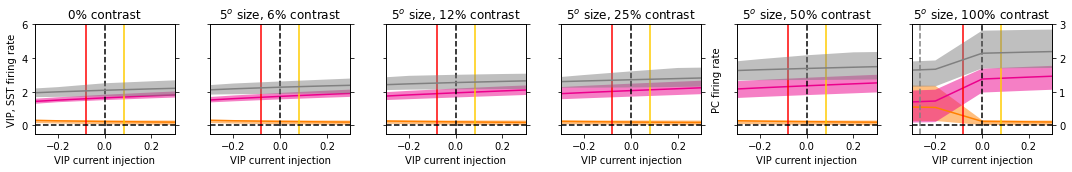

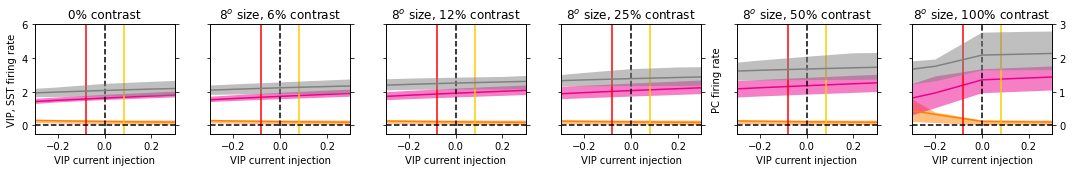

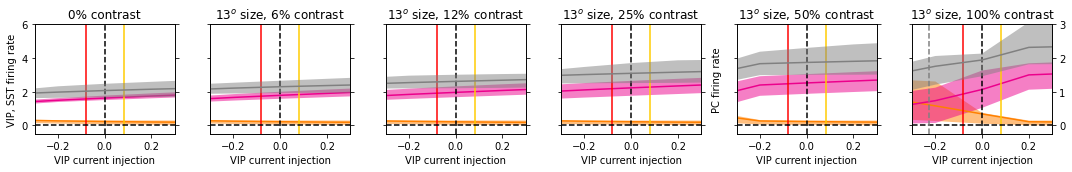

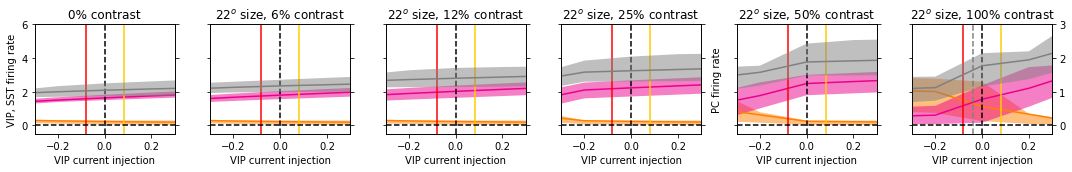

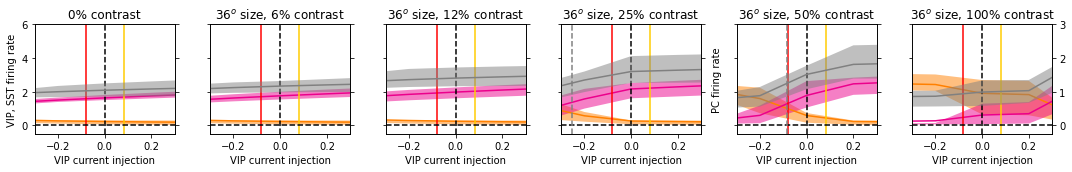

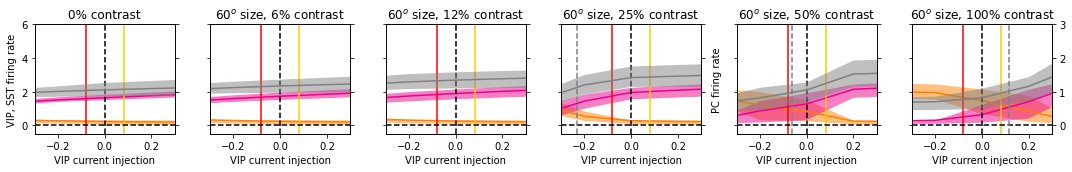

In [ ]:


alpha = 0.5

izero = 15
zero_subtracted = False

norm_to_mean = True

lkat = ut.k_and(*[network_resp.max(1).max(1).max(1) < 10 for iconn in [0,2,3,4]])


def plot_nonlinearity(ax, network_resp,color,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = network_resp - network_resp[:,izero:izero+1]
    else:
        to_plot = network_resp - 0
    ax.plot(opto_levels,np.nanmean(to_plot,0),c=color,label=label)
    ax.fill_between(opto_levels,np.nanpercentile(to_plot,pct_l,axis=0),np.nanpercentile(to_plot,pct_u,axis=0),facecolor=color,alpha=alpha)

def plot_cell_intrinsic_resp(cell_intrinsic_resp,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = cell_intrinsic_resp - cell_intrinsic_resp[:,izero:izero+1]
    else:
        to_plot = cell_intrinsic_resp - 0
    plt.plot(opto_levels,np.nanmean(to_plot,0),c='k',linestyle='dashed',label=label)
    
    
usize = np.array((5,8,13,22,36,60))
# itype = 2
pct_l,pct_u = 16,80
# istims = [0,5,35,18,20,23]
all_titles = [f"{size}$^o$ size, {contrast}% contrast" for size in usize for contrast in ucontrast]
all_titles[0::6] = ["0% contrast" for _ in range(6)]
# titles = ['0% contrast','5$^o$ size, 100% contrast','60$^o$ size, 100% contrast','0% contrast','22$^o$ size, 12% contrast','22$^o$ size, 100% contrast']
cs = [None,np.array((1,0.65,0)),np.array((1,0,1)),None]

this_target_amplitude = np.nanmean(params[:,5::6,0,0],axis=1)
line_loc = this_target_amplitude.mean()

xlim = 0.3 # 0.5

midline=np.mean(params[:,:,0,0],0)

istims_list = [np.arange(k,k+6,1) for k in range(0,36,6)]

for istim_choice in range(len(istims_list)):
    istims = istims_list[istim_choice]
    titles = [all_titles[istim] for istim in istims]
    for istyle in range(1):
        fig, axs = plt.subplots(1,len(istims),figsize=(2.5*len(istims),2.5), sharey=True)
        this_lkat = slice(None)
        for iistim,(istim,title) in enumerate(zip(istims,titles)):

            nrs = [network_resp]
            nr_baseline = network_resp
            cs = [np.array((0.5,0.5,0.5)),np.array((1,0.5,0)),np.array((236, 0, 140))/255,np.array((0,0,1))]
            lbls = ['baseline','PC$\rightarrow$SST weights deleted','PC$\rightarrow$VIP weights deleted','PC$\leftrightarrow$PV weights deleted']
            for iplot,(nr,c,lbl) in enumerate(zip(nrs[:1],cs[:1],lbls[:1])):

                if norm_to_mean:
                    nr = ut.norm_middle_axes_to_mean(nr[:,:,:,:],nr_baseline[:,2,:,:])
                pc_ax = axs[iistim].twinx()
                for itype in range(3):
                    if itype==0:
                        this_ax = pc_ax
                    else:
                        this_ax = axs[iistim]
                    plot_nonlinearity(this_ax, nr[lkat][this_lkat][:,:,istim,itype],cs[itype],lbl)
                axs[iistim].axvline(line_loc,c=np.array((1,0,0)))
                axs[iistim].axvline(-line_loc,c=np.array((1,0.8,0)))
                axs[iistim].axvline(0,c='k',linestyle='dashed')
                axs[iistim].axhline(0,c='k',linestyle='dashed')
                axs[iistim].axvline(midline[istim],c='gray',linestyle='dashed')
                
                if istyle == 2:
                    axs[iistim].set_xlim((-0.5, 0.5))
                else:
                    axs[iistim].set_xlim((-xlim, xlim))

                if norm_to_mean:
                    axs[iistim].set_ylim((-0.5,6))
                    pc_ax.set_ylim((-0.25, 3.0))
                else:
                    axs[iistim].set_ylim((-1,3))
                    pc_ax.set_ylim((-1, 3))

                if iistim < len(istims)-1:
                    pc_ax.set_yticklabels([])


                axs[iistim].set_xlabel('VIP current injection')
                if zero_subtracted:
                    axs[iistim].set_ylabel(r'$\Delta$firing rate')
                else:
                    if iistim == 0:
                        axs[iistim].set_ylabel('VIP, SST firing rate')
                    if iistim == 3:
                        pc_ax.set_ylabel('PC firing rate')
            fig.tight_layout()
            axs[iistim].set_title(title)
            fig.tight_layout()
            save = False

# plt.savefig(figures_path+'/network_nonlinearity_all_connections_size_contrast_samples.pdf',dpi=300)